# Predict target features (brown dwarf parameters) using trained CNN model

In [1]:
import sys  
sys.path.insert(0, '../telescopeML/')

from ObservPredictor import *
from DeepRegBuilder import *
from StatVisAnalyzer import regression_report, chi_square_test, plot_chi_square_p_value

Loading BokehJS ...

Loading BokehJS ...

# Step 1: Load the training dataset (syntheric spectra)

In [2]:
# original trainign dataset astronomers use to predict the parameters of the telescope brown dwarf spectra

train_BD = pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
train_BD.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


### Check the columns
note: one of the columns, *is_augmented*, is indicating wheter this is a native dataset or an augmented one. For now, we don't need it so drop it, but all modules will take this into account! 

In [3]:
target_features = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[target_features].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In [4]:
training_features_labels = [item for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_labels[:5]

['2.512', '2.487', '2.462', '2.438', '2.413']

In [5]:
training_features_wl = [float(item) for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_wl[:5]

[2.512, 2.487, 2.462, 2.438, 2.413]

In [6]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


## Prepare feature variables (X) and targets (y)

In [7]:
# to assure we are only training the module with the native non-augmented BD training dataset
train_BD = train_BD[train_BD['is_augmented'].isin(['no'])] 


# Training feature variables
X = train_BD.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)


# Target feature variables
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [8]:
y.loc[:, 'temperature'] = np.log10(y['temperature'])

/var/folders/30/n2yd25m90v1bywy0rcgx4fqc0000gq/T/ipykernel_98932/1983952283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, 'temperature'] = np.log10(y['temperature'])


In [9]:
y.head()

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Build the CNN model / Data processing

In [10]:
# Instintiate TrainCNNRegression class
build_cnn_regression = BuildRegression(feature_values=X.to_numpy(),
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

#### Split the dataset into train, validate and test sets

In [11]:
build_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1, random_state_=100,)

In [12]:
# Scale the X features using MinMax Scaler
build_cnn_regression.standardize_X_row_wise()

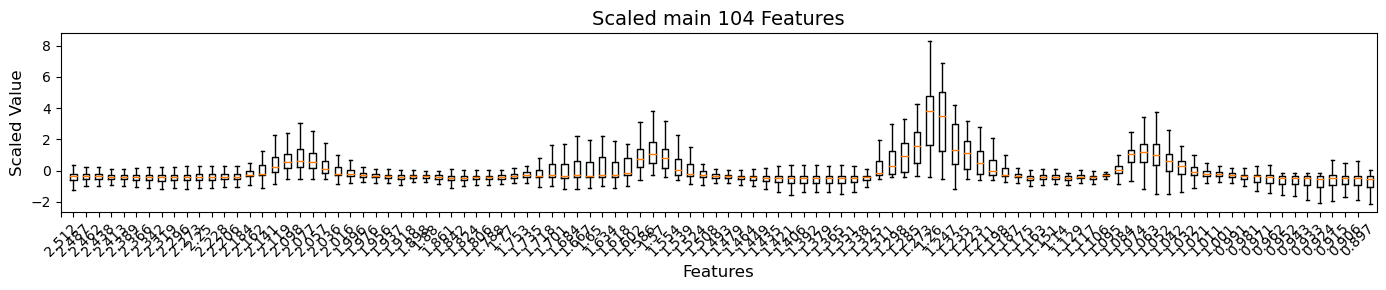

In [13]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.X_train_standardized_rowwise, 
                                                  xticks_list = training_features_labels,
                                                  title = 'Scaled main 104 Features',
                                                  fig_size=(14, 3),
                                                    )

### Scale y features - ColumnWise

In [14]:
# Standardize the y features using Standard Scaler
build_cnn_regression.standardize_y_column_wise()

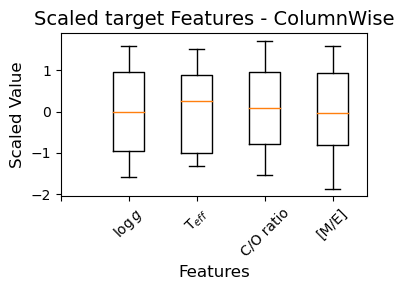

In [15]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.y_train_standardized_columnwise, 
                                                  xticks_list = ['','$\log g$', 'T$_{eff}$', 'C/O ratio', '[M/E]'],
                                                  title = 'Scaled target Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

In [16]:
# build_cnn_regression.y_train_standardized_columnwise

### Feature engeenering: Take Min and Max of each row (BD spectra) 

In [17]:
# train
build_cnn_regression.X_train_min = build_cnn_regression.X_train.min(axis=1)
build_cnn_regression.X_train_max = build_cnn_regression.X_train.max(axis=1)

# validation
build_cnn_regression.X_val_min = build_cnn_regression.X_val.min(axis=1)
build_cnn_regression.X_val_max = build_cnn_regression.X_val.max(axis=1)

# test
build_cnn_regression.X_test_min = build_cnn_regression.X_test.min(axis=1)
build_cnn_regression.X_test_max = build_cnn_regression.X_test.max(axis=1)

In [18]:
df_MinMax_train = pd.DataFrame((build_cnn_regression.X_train_min, build_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((build_cnn_regression.X_val_min, build_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((build_cnn_regression.X_test_min, build_cnn_regression.X_test_max)).T

In [19]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [20]:
df_MinMax_train.head()

,min,max
0,2.984493e-18,4.560593e-11
1,6.833671e-15,2.317328e-09
2,2.870361e-14,5.564836e-09
3,5.696652e-19,5.071436e-11
4,1.321553e-10,1.636513e-07


### Scale Min Max features - ColumnWise

In [21]:
build_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

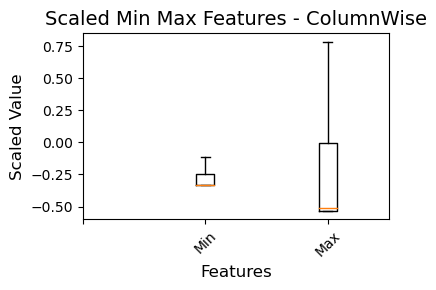

In [22]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.X_test_standardized_columnwise, 
                                                  xticks_list = ['','Min','Max'],
                                                  title = 'Scaled Min Max Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

# Step 3: Load the Trained CNN model

In [23]:
# model = load_model('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters__random42_v1.h5')
# model.load_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters__newbuild_random42_v1.h5')

# # Loading the saved history object
# with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters__newbuild_random42_v1.pkl', 'rb') as file:
#     history = pk.load(file)    

In [24]:
# from tensorflow.keras.models import load_model
# model = load_model('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters_v4_1000epoch_v2.h5')
# model.load_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters_v4_1000epoch_v2.h5')

# # Loading the saved history object
# with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters_v4_1000epoch_v2.pkl', 'rb') as file:
#     history = pk.load(file)    

In [25]:
model = load_model('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters__random42_v1.h5')
model.load_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters__newbuild_random42_v1.h5')

# Loading the saved history object
with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters__newbuild_random42_v1.pkl', 'rb') as file:
    history = pk.load(file) 

2023-08-02 16:16:28.212878: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
build_cnn_regression.trained_model = model
build_cnn_regression.trained_model_history = history

### Check the CNN archeticture

In [27]:
tf.keras.utils.plot_model(
                build_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [28]:
build_cnn_regression.trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 104, 1)]     0                                            
__________________________________________________________________________________________________
Conv__B1_L1 (Conv1D)            (None, 104, 32)      128         input_1[0][0]                    
__________________________________________________________________________________________________
Conv__B1_L2 (Conv1D)            (None, 104, 128)     12416       Conv__B1_L1[0][0]                
__________________________________________________________________________________________________
Conv__B1_L3 (Conv1D)            (None, 104, 288)     110880      Conv__B1_L2[0][0]                
______________________________________________________________________________________________

### Check the performance of the trained models

In [29]:
build_cnn_regression.plot_model_loss(history=history, title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Plot predicted Vs. Actual outcomes: Histogram & Scatter plot

In [30]:
# i = 1
# regression_report(
#         trained_model = build_cnn_regression,
    
#         Xtrain = [build_cnn_regression.X_train_standardized_rowwise[::i],
#                   build_cnn_regression.X_train_standardized_columnwise[::i]],
    
#         Xtest  = [build_cnn_regression.X_test_standardized_rowwise[::i], 
#                   build_cnn_regression.X_test_standardized_columnwise[::i]],
    
#         ytrain = build_cnn_regression.y_train_standardized_columnwise[::i],
    
#         ytest  = build_cnn_regression.y_test_standardized_columnwise[::i],
    
#         target_i = 4,
        
#         xy_top   = [0.05, 0.7],
#         xy_bottom= [0.05, 0.85],
#         print_results = False,        
#                  )

# Step 4: Predict Observational data using the trained CNN model

Steps: 
- Define the literature reported data for the object
- Instintiate ObsParameterPredictor class
- load_observational_spectra
    - replace negative Flam with zero
    - take the average of neibougrs for Flam_error <= 0
    - plot_observational_spectra_errorbar_
- Process_Observational_Dataset
    - Instintiate ProcessObservationalDataset class
    - define feature_names_synthetic and feature_names_obs
    - flux_interpolated
    - 

---

## HD 3651B

#### Define the literature data reported for this object


In [31]:

HD3651B_BD_literature_info = {'bd_name':'HD3651B',
          'bd_Teff':818,
          'bd_logg':3.94,
          'bd_met': -0.22, 
          'bd_distance_pc' : 11.134, 
          'bd_radius_Rjup' : 0.81,
          'bd_radius_Rjup_tuned': None} #0.81


#### Instintiate the *ObsParameterPredictor* class from *ObservPredictor* module

In [32]:
brown_dwarf_literature_info = HD3651B_BD_literature_info
predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = build_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [33]:
# Load the observational spectra
predict.load_observational_spectra()

# Process the observational dataset
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

2023-08-02 16:16:29.364409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


#### Deploy the trained CNN model & Predict the target features 

******************************

Predicted Targets from Randomly Generated Spectra:
{   'c_o_ratio': 1.7295095920562744,
    'gravity': 4.98209285736084,
    'metallicity': -0.4977370798587799,
    'temperature': 766.2255859375}
******************************

            logg        c_o        met           T
count  10.000000  10.000000  10.000000   10.000000
mean    4.982093   1.729510  -0.497737  766.225586
std     0.086775   0.185605   0.007330   26.125301
min     4.856957   1.531263  -0.510364  723.902649
25%     4.894797   1.543251  -0.502813  747.604050
50%     5.030095   1.721108  -0.496108  769.249268
75%     5.042612   1.878746  -0.493734  781.206039
max     5.080782   1.998705  -0.487986  802.611267


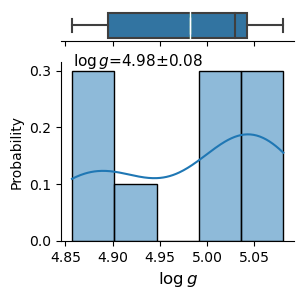

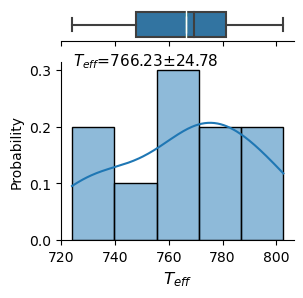

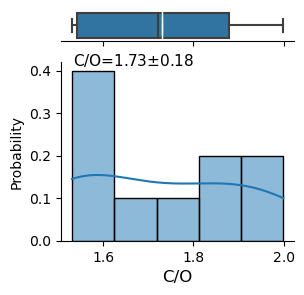

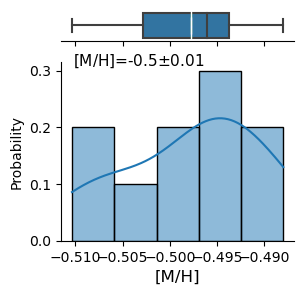

In [35]:
predict.predict_from_random_spectra(random_spectra_num= 10,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

Comennet from natasha: >2.2 mincron - Is not missing any thing!
> 1 sigma error 
> training set
> trusing the posterior space 

### Tune the brown dwarf Radius

#### What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [33]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.81 R_Jup:  𝛘2 = 62.97, p-value = 9.99e-01


(62.97, '9.99e-01')

#### What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [34]:
def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl = wl, 
                                        train_cnn_regression_class = build_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [35]:
print_results_fun(brown_dwarf_literature_info, print_title= 'HD3651B: Literature reported Info')

******************************

HD3651B: Literature reported Info
{   'bd_Teff': 818,
    'bd_distance_pc': 11.134,
    'bd_logg': 3.94,
    'bd_met': -0.22,
    'bd_name': 'HD3651B',
    'bd_radius_Rjup': 0.81,
    'bd_radius_Rjup_tuned': None}
******************************



In [36]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.3, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.3, 
                                                    dR = 0.01,
                                                    brown_dwarf_literature_info = brown_dwarf_literature_info,
                                                    __plot_results__=False,
                                                    __print_results__=True,
                                                    __plot_stat_results__=True,)

Radius = 0.51 R_Jup:  𝛘2 = 44.07, p-value = 1.00e+00
Radius = 0.52 R_Jup:  𝛘2 = 97.46, p-value = 6.35e-01
Radius = 0.53 R_Jup:  𝛘2 = 66.1, p-value = 9.98e-01
Radius = 0.54 R_Jup:  𝛘2 = 84.03, p-value = 9.14e-01
Radius = 0.55 R_Jup:  𝛘2 = 77.8, p-value = 9.70e-01
Radius = 0.56 R_Jup:  𝛘2 = 67.8, p-value = 9.97e-01
Radius = 0.57 R_Jup:  𝛘2 = 69.33, p-value = 9.96e-01
Radius = 0.58 R_Jup:  𝛘2 = 97.08, p-value = 6.46e-01
Radius = 0.59 R_Jup:  𝛘2 = 31.26, p-value = 1.00e+00
Radius = 0.60 R_Jup:  𝛘2 = 257.83, p-value = 2.89e-15
Radius = 0.61 R_Jup:  𝛘2 = 69.44, p-value = 9.95e-01
Radius = 0.62 R_Jup:  𝛘2 = 65.35, p-value = 9.99e-01
Radius = 0.63 R_Jup:  𝛘2 = 133.62, p-value = 2.29e-02
Radius = 0.64 R_Jup:  𝛘2 = 126.84, p-value = 5.55e-02
Radius = 0.65 R_Jup:  𝛘2 = 62.0, p-value = 1.00e+00
Radius = 0.66 R_Jup:  𝛘2 = 162.38, p-value = 1.72e-04
Radius = 0.67 R_Jup:  𝛘2 = 114.97, p-value = 1.98e-01
Radius = 0.68 R_Jup:  𝛘2 = 150.15, p-value = 1.69e-03
Radius = 0.69 R_Jup:  𝛘2 = 127.26, p-value =

---

## Ross 458C

#### Define the literature data reported for this object

In [36]:
Ross458C_BD_literature_info = {'bd_name':'Ross458C',
          'bd_Teff':804,
          'bd_logg':4.09,
          'bd_met': 0.23, 
          'bd_distance_pc' : 11.509, 
          'bd_radius_Rjup' :  0.68,
          'bd_radius_Rjup_tuned': None } #1.0 * 0.68 


#### Instintiate the *ObsParameterPredictor* class from *ObservPredictor* module

In [37]:
brown_dwarf_literature_info = Ross458C_BD_literature_info
predict_ = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = build_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [38]:
# Load the observational spectra
predict.load_observational_spectra()

# Process the observational dataset
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

#### Deploy the trained CNN model & Predict the target features 

******************************

Predicted Targets from Randomly Generated Spectra:
{   'c_o_ratio': 1.769040584564209,
    'gravity': 4.940258979797363,
    'metallicity': -0.49629145860671997,
    'temperature': 764.9425048828125}
******************************

             logg         c_o         met           T
count  100.000000  100.000000  100.000000  100.000000
mean     4.940259    1.769041   -0.496291  764.942505
std      0.130087    0.172136    0.008355   22.734747
min      4.654119    1.321796   -0.521694  716.629944
25%      4.830820    1.654470   -0.501103  745.854965
50%      4.964556    1.798544   -0.495052  767.678955
75%      5.035948    1.885819   -0.490135  781.402069
max      5.247956    2.153609   -0.474412  812.781128


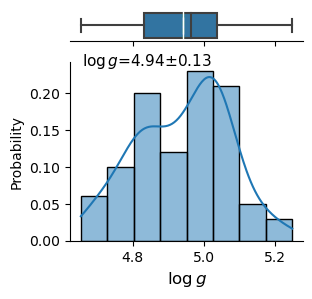

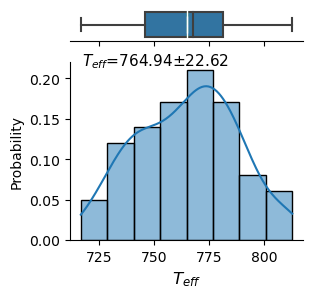

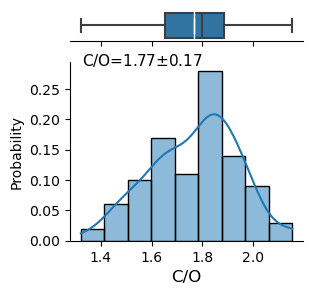

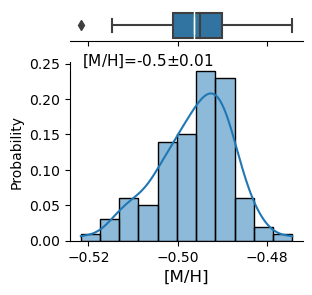

In [39]:
predict.predict_from_random_spectra(random_spectra_num= 100,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

### Tune the brown dwarf Radius

#### What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [40]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.68 R_Jup:  𝛘2 = 808.91, p-value = 0.00e+00


(808.91, '0.00e+00')

#### What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [41]:
def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl = wl, 
                                        train_cnn_regression_class = build_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [42]:
print_results_fun(brown_dwarf_literature_info, print_title= 'Ross458C: Literature reported Info')

******************************

Ross458C: Literature reported Info
{   'bd_Teff': 804,
    'bd_distance_pc': 11.509,
    'bd_logg': 4.09,
    'bd_met': 0.23,
    'bd_name': 'Ross458C',
    'bd_radius_Rjup': 0.68,
    'bd_radius_Rjup_tuned': None}
******************************



In [43]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.2, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.2, 
                                                    dR = 0.01,
                                                    brown_dwarf_literature_info = brown_dwarf_literature_info,
                                                    __plot_results__=False,
                                                    __print_results__=True,
                                                    __plot_stat_results__=True,)

Radius = 0.48 R_Jup:  𝛘2 = 555.11, p-value = 0.00e+00
Radius = 0.49 R_Jup:  𝛘2 = 902.3, p-value = 0.00e+00
Radius = 0.50 R_Jup:  𝛘2 = 2391.85, p-value = 0.00e+00
Radius = 0.51 R_Jup:  𝛘2 = 835.63, p-value = 0.00e+00
Radius = 0.52 R_Jup:  𝛘2 = 1685.58, p-value = 0.00e+00
Radius = 0.53 R_Jup:  𝛘2 = 441.98, p-value = 0.00e+00
Radius = 0.54 R_Jup:  𝛘2 = 2490.19, p-value = 0.00e+00
Radius = 0.55 R_Jup:  𝛘2 = 1960.58, p-value = 0.00e+00
Radius = 0.56 R_Jup:  𝛘2 = 475.93, p-value = 0.00e+00
Radius = 0.57 R_Jup:  𝛘2 = 6373.65, p-value = 0.00e+00
Radius = 0.58 R_Jup:  𝛘2 = 3511.89, p-value = 0.00e+00
Radius = 0.59 R_Jup:  𝛘2 = 1642.75, p-value = 0.00e+00
Radius = 0.60 R_Jup:  𝛘2 = 5584.35, p-value = 0.00e+00
Radius = 0.61 R_Jup:  𝛘2 = 470.57, p-value = 0.00e+00
Radius = 0.62 R_Jup:  𝛘2 = 1453.04, p-value = 0.00e+00
Radius = 0.63 R_Jup:  𝛘2 = 2001.75, p-value = 0.00e+00
Radius = 0.64 R_Jup:  𝛘2 = 3776.28, p-value = 0.00e+00
Radius = 0.65 R_Jup:  𝛘2 = 677.09, p-value = 0.00e+00
Radius = 0.66 R_Ju

KeyboardInterrupt: 

---

## GJ 570D

#### Define the literature data reported for this object

In [44]:
GJ570D_BD_literature_info = {'bd_name':'GJ570D',
          'bd_Teff':828,
          'bd_logg':3.90,
          'bd_met': -0.33, 
          'bd_distance_pc' : 5.884, 
          'bd_radius_Rjup' : 0.79,
          'bd_radius_Rjup_tuned': None } # 0.79

#### Instintiate the *ObsParameterPredictor* class from *ObservPredictor* module

In [45]:
brown_dwarf_literature_info = GJ570D_BD_literature_info

predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = build_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [46]:
# Load the observational spectra
predict.load_observational_spectra()

# Process the observational dataset
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

#### Deploy the trained CNN model & Predict the target features 

******************************

Predicted Targets from Randomly Generated Spectra:
{   'c_o_ratio': 1.809242606163025,
    'gravity': 5.189897060394287,
    'metallicity': -0.49326667189598083,
    'temperature': 776.5234375}
******************************

             logg         c_o         met           T
count  100.000000  100.000000  100.000000  100.000000
mean     5.189897    1.809243   -0.493267  776.523438
std      0.134085    0.203036    0.009886   30.802315
min      4.847941    1.377497   -0.520041  682.336609
25%      5.116311    1.678028   -0.499552  752.650085
50%      5.201343    1.822792   -0.491587  782.796265
75%      5.284984    1.944669   -0.486273  799.623978
max      5.453146    2.417748   -0.474526  841.516541


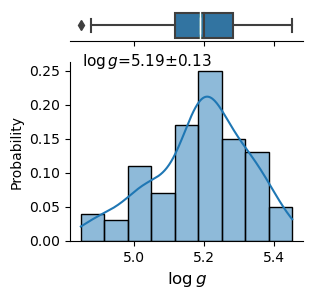

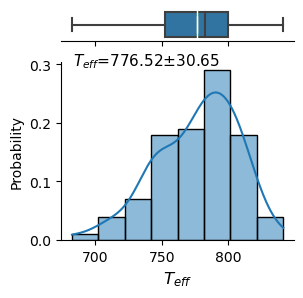

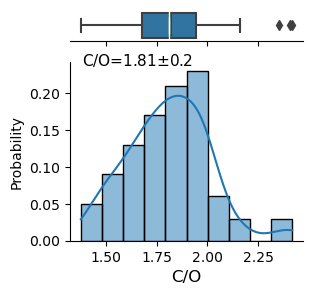

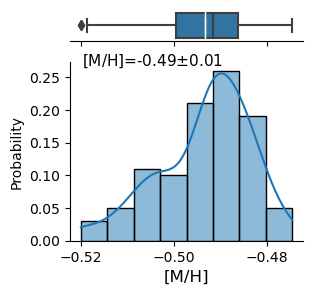

In [47]:
predict.predict_from_random_spectra(random_spectra_num= 100,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

### Tune the brown dwarf Radius

#### What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [48]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.79 R_Jup:  𝛘2 = 680.87, p-value = 0.00e+00


(680.87, '0.00e+00')

#### What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [49]:
def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl = wl, 
                                        train_cnn_regression_class = build_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [50]:
print_results_fun(brown_dwarf_literature_info, print_title= 'GJ570D: Literature reported Info')

******************************

GJ570D: Literature reported Info
{   'bd_Teff': 828,
    'bd_distance_pc': 5.884,
    'bd_logg': 3.9,
    'bd_met': -0.33,
    'bd_name': 'GJ570D',
    'bd_radius_Rjup': 0.79,
    'bd_radius_Rjup_tuned': None}
******************************



In [51]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.2, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.2, 
                                                    dR = 0.01,
                                                    brown_dwarf_literature_info = brown_dwarf_literature_info,
                                                    __plot_results__=False,
                                                    __print_results__=True,
                                                    __plot_stat_results__=True,)

Radius = 0.59 R_Jup:  𝛘2 = 711.84, p-value = 0.00e+00
Radius = 0.60 R_Jup:  𝛘2 = 605.31, p-value = 0.00e+00
Radius = 0.61 R_Jup:  𝛘2 = 419.7, p-value = 0.00e+00
Radius = 0.62 R_Jup:  𝛘2 = 516.79, p-value = 0.00e+00
Radius = 0.63 R_Jup:  𝛘2 = 728.88, p-value = 0.00e+00
Radius = 0.64 R_Jup:  𝛘2 = 538.04, p-value = 0.00e+00
Radius = 0.65 R_Jup:  𝛘2 = 537.41, p-value = 0.00e+00
Radius = 0.66 R_Jup:  𝛘2 = 1149.23, p-value = 0.00e+00
Radius = 0.67 R_Jup:  𝛘2 = 823.49, p-value = 0.00e+00
Radius = 0.68 R_Jup:  𝛘2 = 1296.44, p-value = 0.00e+00
Radius = 0.70 R_Jup:  𝛘2 = 1026.2, p-value = 0.00e+00
Radius = 0.71 R_Jup:  𝛘2 = 395.48, p-value = 0.00e+00
Radius = 0.72 R_Jup:  𝛘2 = 492.08, p-value = 0.00e+00
Radius = 0.73 R_Jup:  𝛘2 = 771.1, p-value = 0.00e+00
Radius = 0.74 R_Jup:  𝛘2 = 229.22, p-value = 1.34e-11
Radius = 0.75 R_Jup:  𝛘2 = 278.37, p-value = 0.00e+00
Radius = 0.76 R_Jup:  𝛘2 = 660.13, p-value = 0.00e+00
Radius = 0.77 R_Jup:  𝛘2 = 400.26, p-value = 0.00e+00
Radius = 0.78 R_Jup:  𝛘2 = 4

### GJ 570D with optimised Radius

In [71]:
GJ570D_BD_literature_info = {'bd_name':'GJ570D',
          'bd_Teff':828,
          'bd_logg':3.90,
          'bd_met': -0.33, 
          'bd_distance_pc' : 5.884, 
          'bd_radius_Rjup' : 0.77,
          'bd_radius_Rjup_tuned': None } # Original radius = 0.79

In [72]:
brown_dwarf_literature_info = GJ570D_BD_literature_info

predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = build_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [73]:
# Load the observational spectra
predict.load_observational_spectra()

# Process the observational dataset
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

******************************

Predicted Targets from Randomly Generated Spectra:
{   'c_o_ratio': 1.5773489475250244,
    'gravity': 5.2019944190979,
    'metallicity': -0.3895178735256195,
    'temperature': 872.046142578125}
******************************

             logg         c_o         met           T
count  100.000000  100.000000  100.000000  100.000000
mean     5.201994    1.577349   -0.389518  872.046143
std      0.151152    0.249969    0.050050   29.268232
min      4.757962    1.041286   -0.478551  795.777039
25%      5.117166    1.418575   -0.422218  856.270737
50%      5.208026    1.555785   -0.401749  872.536133
75%      5.298102    1.682324   -0.362353  889.893906
max      5.578898    2.375693   -0.198074  948.081665


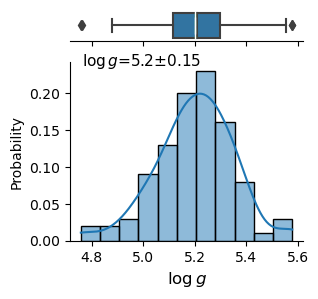

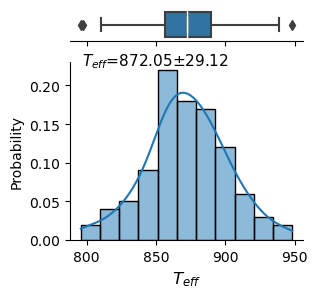

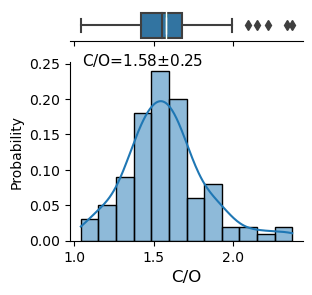

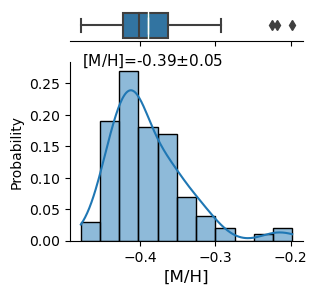

In [74]:
predict.predict_from_random_spectra(random_spectra_num= 100,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

---

#                      THE  END 